In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import math
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import pygraphviz
import matplotlib.pyplot as plt

In [2]:
def corr_matrix(df, window=250, enddate="2017-01-24", method="gower"):
    """To generate correlation matrix for a certain period, method = 'gower' or 'power'"""
    end = int(np.where(df.index==enddate)[0])
    start = end - window + 1
    sub = df[start:end+1]
    #print(sub)
    corr_mat = sub.corr(min_periods=150)
    if method == "gower":
        corr_mat = (2-2*corr_mat[corr_mat.notnull()])**0.5# gower
    elif method == "power":
        corr_mat = 1-corr_mat[corr_mat.notnull()]**2# power
    #corr_mat.apply(lambda x:1-x**2 if not math.isnan(x) else np.nan)
    return corr_mat
## still need to deal with the situation when enddate is not in the index.

In [3]:
def rolling_corr(df, window=250, enddate="2017-01-24", startdate='2005-01-03',space=10):
    """Return a dictionary of correlation matrices.
    The key is the enddate of the window, the value is corresponding correlation matrix"""
    end = int(np.where(df.index==enddate)[0])
    start = int(np.where(df.index==startdate)[0])
    space = -space
    dates = df.index.values
    dates = dates[end:start:space]
    result = {}
    for d in dates:
        d = pd.to_datetime(d).strftime("%Y-%m-%d")
        result[str(d)] = corr_matrix(df, window, enddate=d)
    return result

In [4]:
def constructgraph(corr_matrix):
    """Convert a correlation matrix to a graph"""
    G = nx.from_numpy_matrix(corr_matrix.values)
    mapping = dict(zip(list(range(127)),list(corr_matrix.index)))
    G = nx.relabel_nodes(G, mapping, copy=False)
    #delete NAN weights
    for (u,v,d) in G.edges(data=True):
        if math.isnan(d["weight"]):
            G.remove_edges_from([(u,v)])
    #delete self-connected edges
    for (u,v,d) in G.edges(data=True):
        if u==v:
            G.remove_edges_from([(u,v)])
    #delete nodes whose degree is 0
    nodes = list(G.nodes())
    for node in nodes:
        if G.degree(node) == 0:
            G.remove_node(node)
    return G

In [5]:
def draw_network(G):
    # Define a layout for the graph
    #pos=nx.spring_layout(G) # positions for all nodes
    pos=graphviz_layout(G) # positions for all nodes
    fig=plt.figure(1,figsize=(40,40)) #Let's draw a big graph so that it is clearer

    # draw the nodes: red, sized, transperancy
    nx.draw_networkx_nodes(G, pos, 
                           node_color='r',
                           node_size=100,
                           alpha=.8)

    # draw the edges
    nx.draw_networkx_edges(G,pos,
                           edgelist=list(G.edges()),
                           width=0.5,alpha=0.5,edge_color='b')


    node_name={}
    for node in G.nodes():
        node_name[node]=str(node)


    nx.draw_networkx_labels(G,pos,node_name,font_size=16)

    plt.axis('off')
    plt.show()

In [6]:
def importdata(filename):
    df = pd.read_csv(filename)
    # set date as index and sort by date
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.set_index(pd.DatetimeIndex(df['Date']))
    df = df.drop(['Date'], axis=1)
    df.sort_index(inplace=True)
    # forward fill for NA
    df.fillna(method='ffill')
    # Log return
    log_ret = np.log(df) - np.log(df.shift(1))
    return df, log_ret

In [7]:
def MST(filename="SP100_prices.csv", window=250, enddate="2017-01-24", startdate='2015-12-30',space=1):
    """Return a dictionary of Minimum Spanning Tree for each end date"""
    log_ret = importdata(filename)[1]
    dic = rolling_corr(log_ret, window, enddate, startdate, space)
    trees = {}
    for key in sorted(dic.keys()):
        corr_matrix = dic[key]
        G = constructgraph(corr_matrix)
        T = nx.minimum_spanning_tree(G, "weight")    
        trees[key] = T
    return trees

#### 　
#### Save MST.py (not .ipynb) in your current working directory and run the following code to import functions.
#### Or you can directly add your codes in this file.

In [8]:
# from MST import MST, draw_network

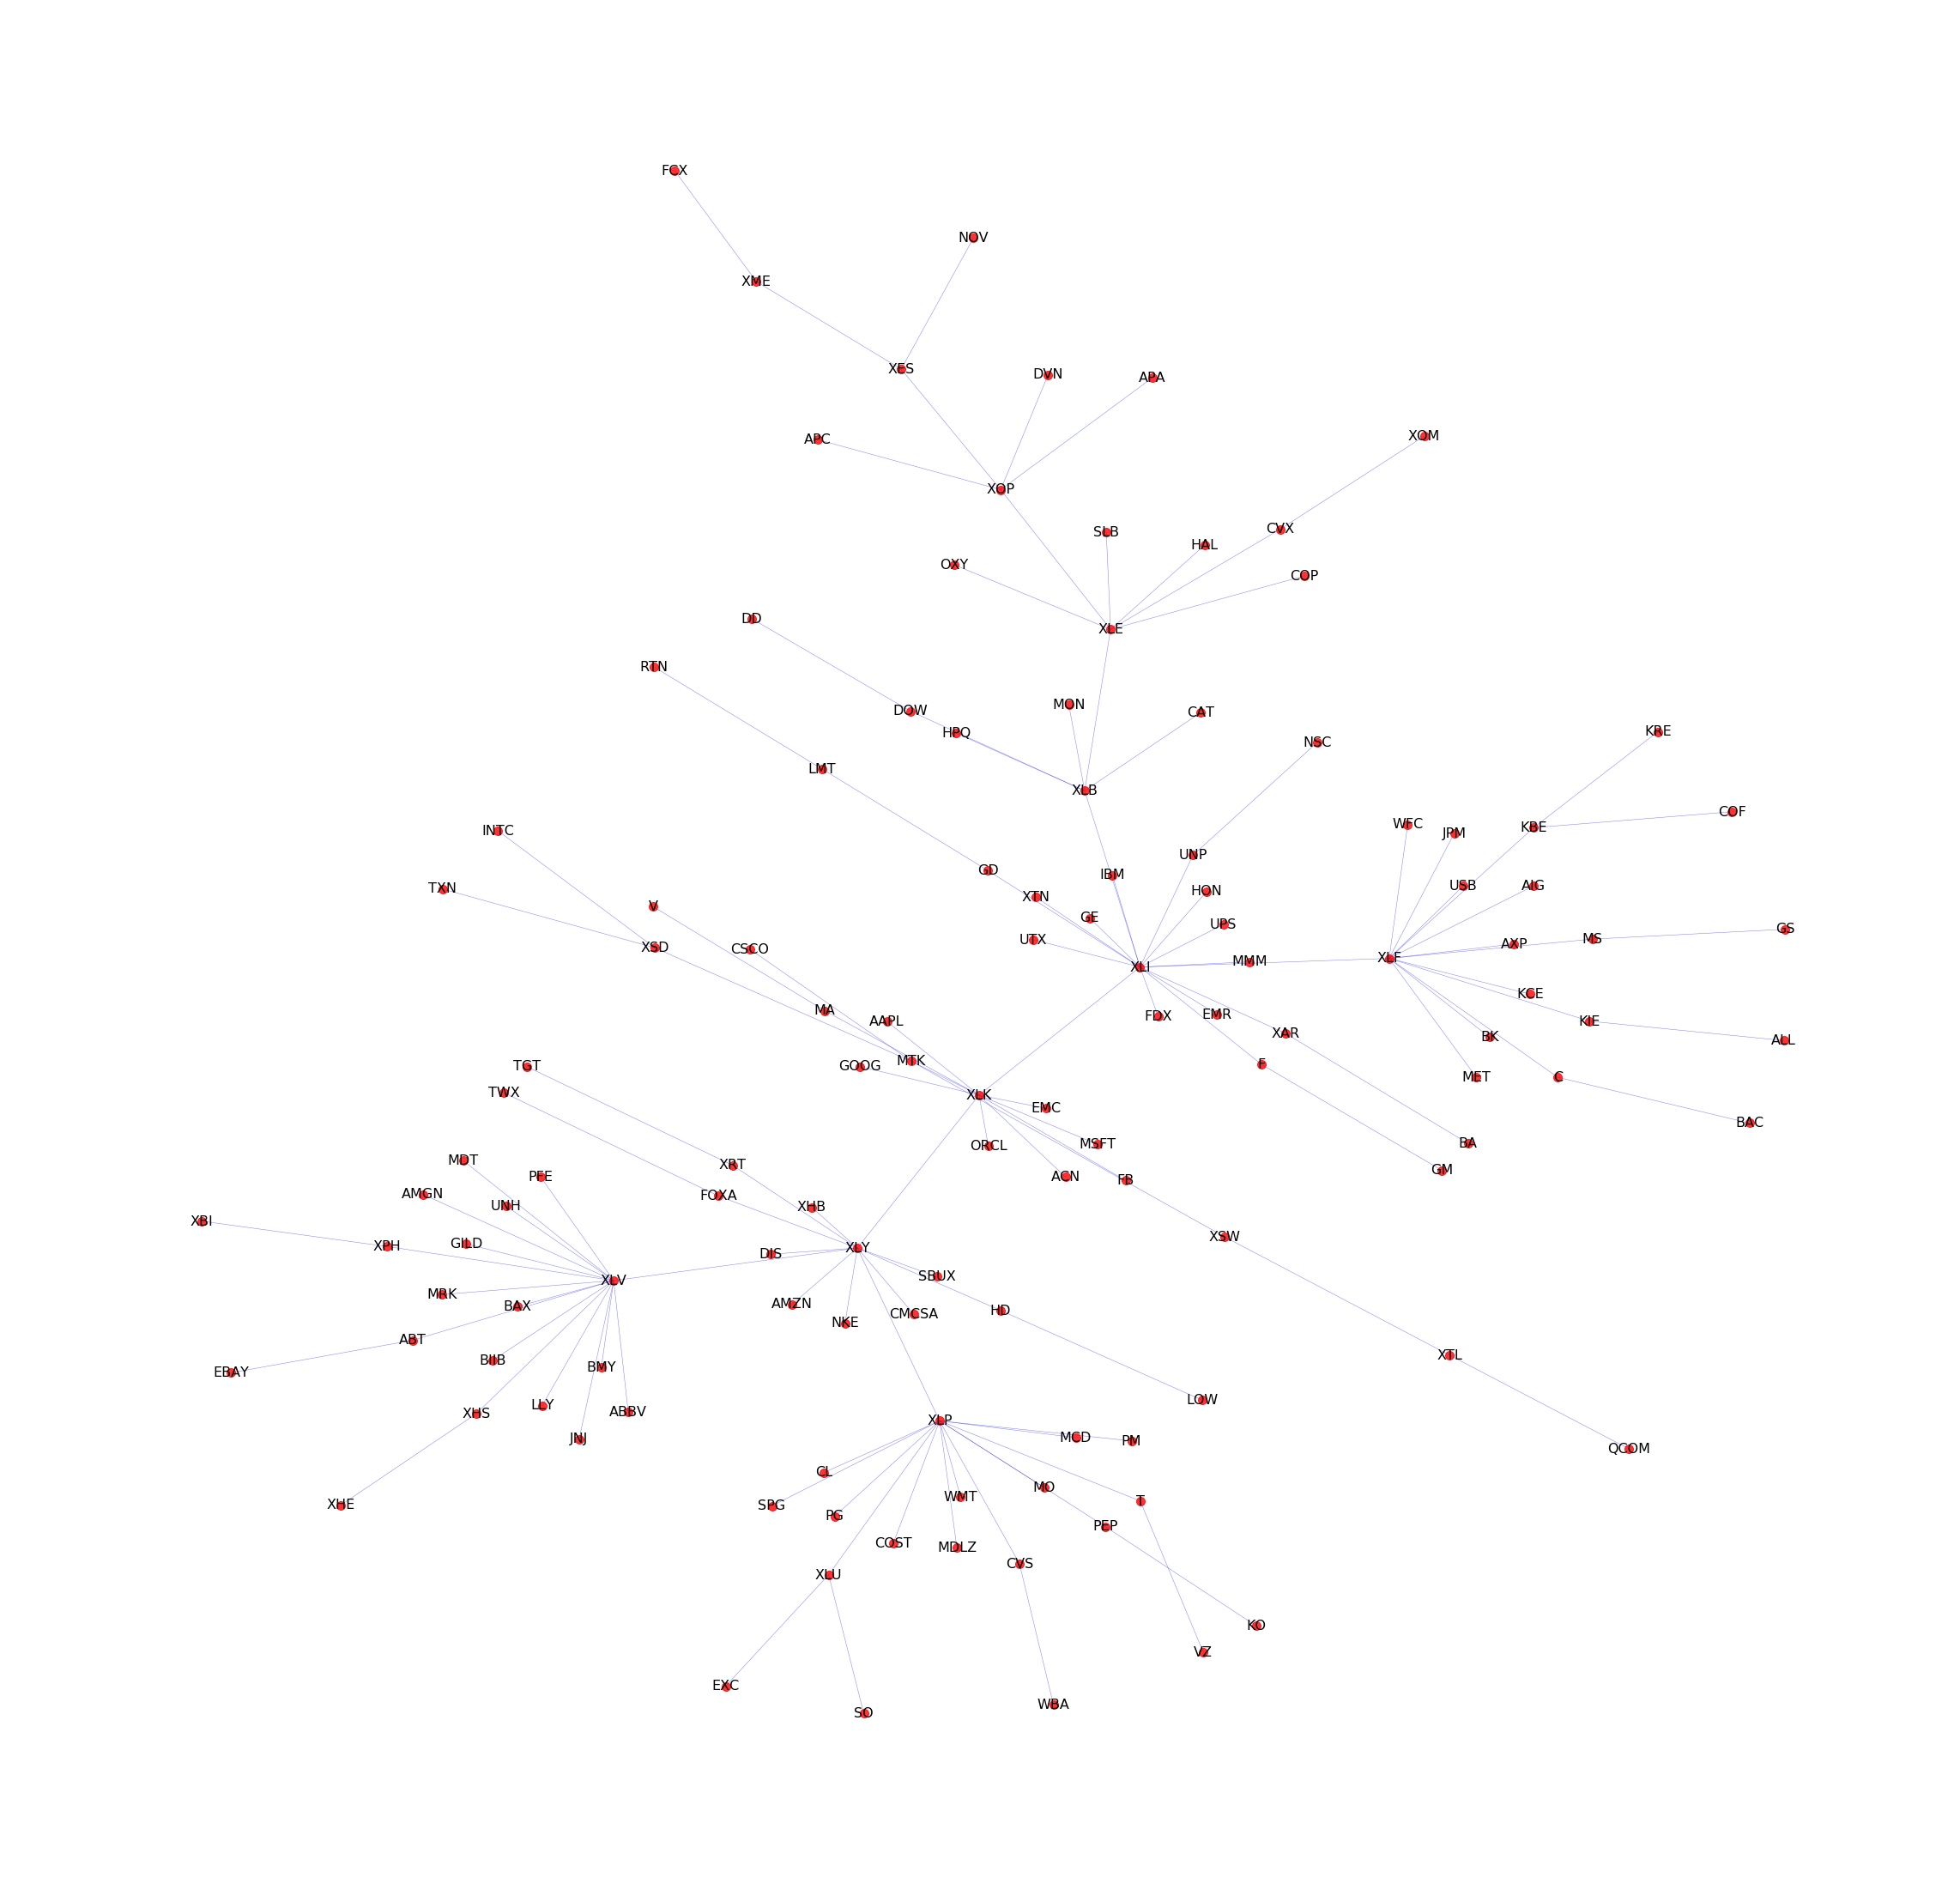

In [9]:
# trees = MST()
# T1 = trees[trees.keys()[0]]
# draw_network(T1)